Here I look at the function of genes interrupted by a given IS during the course of the LTEE, using the NC_012967.ptt file as a reference to see what is at a given position. I exclude essential genes from the analysis. I also perform Fisher's statistical test to see whether the results are significant.

In [1]:
ref = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/ref/"
data = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/LTEE-clone-curated/"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [3]:
def extract_positions(IS_name):
    '''Generates a dictionary listing the position of insertions that occured at some point in at least
    one of the clones of one of the populations (only one occurrence per position, even if it occured
    in different populations).
    Format: {IS position: [position, orientation]}'''
    
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir(data) if isfile(join(data, f))] #listing all file names for the .gd files
    files = [] # creating a list that will first contain these names to be called, and later on open .gd files
    file_names = [] # list that will contain names as strings (kept as such for all the analysis)
    readlines_names = [] #list that will contain lists with the lines of each file (obtained via readlines())
    for i in onlyfiles: #fixing an error in the list of files (I don't know why it occurs) and filling the previously defined lists
        if len(i) < 30:
            files.append(i)
            file_names.append(i)
            readlines_names.append(i)
    
    
    for i in range(len(files)):
        files[i] = open(data+files[i],"r") #the list files becomes a list of open files
        readlines_names[i] = files[i].readlines() # the list readlines_names becomes a list of lists, with each list containing 
        #all the lines from one file
        
    insertion_positions = {} # Creating a dictionary to hold the positions of the insertions
    for i in range(len(file_names)): # for each file
        for line in readlines_names[i]: #we look at all the lines in the corresponding readlines_names entry
            line = line.split()
            if 'MOB' in line and IS_name in line: #if the line corresponds to a mutation linked to the IS
                insertion_positions[line[4]] = [line[4], line[6]] #we add an entry for this IS position to our dictionary
                # and save the orientation as well
    
    return insertion_positions
    

In [4]:
def curate_essential_genes_list():
    '''Generates a list of essential genes based on a file provided in Goodall et al. 
    This is necessary for further analysis of targeted gene functions.'''
    list_essential_genes = []
    essentiality = open('essentiality_genes.csv')
    lines = essentiality.readlines()
    lines = lines[2:]
    for line in lines:
        if line.split(',')[5] == '1':
            list_essential_genes.append(line.split(',')[0])
    return list_essential_genes

In [5]:
def extract_categories(insertion_positions):
    '''Uses the list of insertion sites generated by extract_positions() to extract the name of the genes that are
    interrupted by an IS insertion. The function yields a file with extended information about the genes (output_name) 
    and a file with only the gene names (gene_names_file). A given gene name can appear several times if several
    insertions into that gene were recorded.'''
    
    ref_file = open(ref+'NC_012967.ptt')
    ref_readlines = ref_file.readlines()
    ref_readlines = ref_readlines[3:] # we don't need the 3 first lines
    
    categories = [] #list of categories of genes interrupted by the IS
    
    list_essential_genes = curate_essential_genes_list()
    
    positions_present = 0
    positions_absent = 0
    category_present = 0
    category_absent = 0
    essential_genes = 0
    
    dict_genes_by_cat = {'A':[],'B':[],'C':[],'D':[],'E':[],'F':[],'G':[],
                        'H':[],'I':[],'J':[],'K':[],'L':[],'M':[],'N':[],'O':[],
                        'P':[],'Q':[],'R':[],'S':[],'T':[],'U':[],'V':[],'W':[],
                         'X':[],'Y':[],'Z':[],'unCOG':[]} #creating a dictionary to hold the names of the genes in each category
    
    for position in list(set(insertion_positions)):
        position_found = False
        
        for line_ref in ref_readlines:
            start_finish = line_ref.split()[0].split('..')
            if int(position) >= int(start_finish[0]) and int(position) <= int(start_finish[1]):
                position_found = True
                
                if line_ref.split()[4] not in list_essential_genes:
                    
                    if line_ref.split()[7][-1].isalpha(): 
                        if line_ref.split()[4] != '-':
                            dict_genes_by_cat[line_ref.split()[7][-1]].append(line_ref.split()[4])
                        else:
                            dict_genes_by_cat[line_ref.split()[7][-1]].append(line_ref.split()[5])
                            
                        categories.append(line_ref.split()[7][-1]) #we keep the category
                        
                        category_present += 1 #counting the number of genes for which we found a category
                        
                    else:
                        category_absent += 1
                        categories.append('unCOG')
                        if line_ref.split()[4] != '-':
                            dict_genes_by_cat['unCOG'].append(line_ref.split()[4]) #saving the name of genes that are not categorized
                        else:
                            dict_genes_by_cat['unCOG'].append(line_ref.split()[5]) #taking the ECB_XXXX number if there is no name for the ORF
                        
                else:
                    essential_genes += 1
                
        if not position_found:
            positions_absent += 1
        else:
            positions_present +=1
    
    print('Number of insertions for which the position is listed in the NC.ptt file: ', positions_present)
    print('Number of insertions for which the position is not listed in the NC.ptt file: ', positions_absent)
    print('Number of insertions for which the position is listed but there is no category: ', category_absent)
    print('Number of insertions for which the position is listed and there is a category: ', category_present)
    print('Essential genes interrupted: ', essential_genes)
    print(dict_genes_by_cat)

            
    return categories

In [6]:
def extract_COG_ref_genome():
    '''This function extracts the COG classification of all genes listed in the reference file NC_012967.ptt.
    Essential genes are excluded from the analysis.
    A list with the corresponding letter for each gene is returned.'''
    
    ref_file = open(ref+'NC_012967.ptt','r')
    ref_readlines = ref_file.readlines()
    ref_readlines = ref_readlines[3:]
    
    list_gene_categories = []

    
    list_essential_genes = curate_essential_genes_list()
    
    for line in ref_readlines:
        if line.split()[4] not in list_essential_genes:
            if line.split()[7][-1].isalpha():
                list_gene_categories.append(line.split()[7][-1])
            else:
                list_gene_categories.append('unCOG')
            

    return list_gene_categories

In [7]:
def plot_hist_gene_categories(IS_name):
    '''This function calls those previously defined to plot, for a given IS and for each COG category, the percentage 
    of IS insertions into genes that occur in genes of that category, compared to the percentage of genes of that
    category in the entire REL606 genome. Essential genes are excluded from this analysis.'''

    insertion_positions = extract_positions(IS_name)
    COG_categories_IS = extract_categories(insertion_positions)
    gene_categories_genome = extract_COG_ref_genome()

    labels = sorted(list(set(gene_categories_genome)))
    values_genome = [gene_categories_genome.count(label)/len(gene_categories_genome) for label in labels]
    values_IS = [COG_categories_IS.count(label)/len(COG_categories_IS) for label in labels]

    d = {'Type': ['IS' for i in range(len(labels))]+['genome' for i in range(len(labels))], 
         'Label': sorted(list(set(gene_categories_genome)))+sorted(list(set(gene_categories_genome))), 
        'Value': values_IS + values_genome}

    repartition_genes = pd.DataFrame(data=d)
    
    g = sns.catplot(x="Type", y="Value", col="Label",

                data=repartition_genes, saturation=.5, col_wrap=6,

                kind="bar", ci=None, height=3, aspect = 0.6)

Number of insertions for which the position is listed in the NC.ptt file:  215
Number of insertions for which the position is not listed in the NC.ptt file:  55
Number of insertions for which the position is listed but there is no category:  22
Number of insertions for which the position is listed and there is a category:  193
Essential genes interrupted:  0
{'A': [], 'B': [], 'C': ['aceA', 'pflB', 'fdnH', 'ygfH', 'ydiQ', 'pflB', 'ynfE', 'udhA', 'hyfA', 'ydhV', 'narZ', 'hcp', 'ycdI', 'ygfH'], 'D': ['sulA'], 'E': ['sapA', 'asnB', 'metH', 'dppA', 'gltS', 'metL', 'aroG', 'xasA', 'cycA', 'livK', 'astB', 'asnB', 'sapA', 'dppA', 'yeaS', 'sapA'], 'F': ['rihB', 'ECB_03710', 'ycdG', 'dgt'], 'G': ['ugpB', 'mglB', 'dhaL', 'araE', 'nagE', 'fucI', 'pykF', 'alsA', 'yihS', 'ycjM', 'pykA', 'araG', 'alsA', 'pykF', 'ytfT', 'bglF', 'treC', 'ytfT', 'shiA', 'ycjT', 'ascF', 'pykF', 'rbsD', 'alsA', 'pykF', 'araE', 'sgbE', 'lacZ'], 'H': ['nadR', 'nadR'], 'I': ['fadL', 'fadL', 'aes', 'plsX', 'cls', 'acpD', 'ae

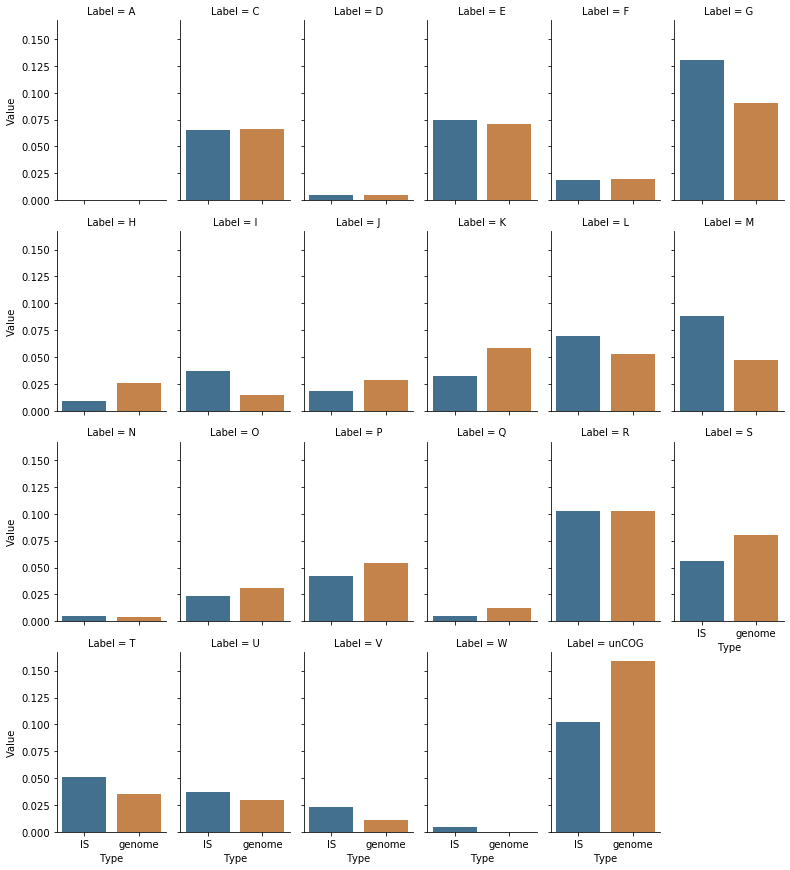

In [8]:
plot_hist_gene_categories('IS150')

In [9]:
def statistical_test(IS_name):
    '''This function calls those previously defined to plot, for a given IS and for each COG category, the percentage 
    of IS insertions into genes that occur in genes of that category, compared to the percentage of genes of that
    category in the entire REL606 genome. Essential genes are excluded from this analysis.'''

    insertion_positions = extract_positions(IS_name)
    COG_categories_IS = extract_categories(insertion_positions)
    gene_categories_genome = extract_COG_ref_genome()

    labels = sorted(list(set(gene_categories_genome)))
    absolute_values_genome = [gene_categories_genome.count(label) for label in labels]
    absolute_values_IS = [COG_categories_IS.count(label) for label in labels]
    
    p_values = {}
    for i in range(len(absolute_values_genome)):
        oddsratio, pvalue = stats.fisher_exact([[absolute_values_genome[i], len(gene_categories_genome) - absolute_values_genome[i]],
                                                [absolute_values_IS[i], len(COG_categories_IS) - absolute_values_IS[i]]])
        p_values[labels[i]] = pvalue
    
    return p_values

In [10]:
statistical_test('IS150')

Number of insertions for which the position is listed in the NC.ptt file:  215
Number of insertions for which the position is not listed in the NC.ptt file:  55
Number of insertions for which the position is listed but there is no category:  22
Number of insertions for which the position is listed and there is a category:  193
Essential genes interrupted:  0
{'A': [], 'B': [], 'C': ['aceA', 'pflB', 'fdnH', 'ygfH', 'ydiQ', 'pflB', 'ynfE', 'udhA', 'hyfA', 'ydhV', 'narZ', 'hcp', 'ycdI', 'ygfH'], 'D': ['sulA'], 'E': ['sapA', 'asnB', 'metH', 'dppA', 'gltS', 'metL', 'aroG', 'xasA', 'cycA', 'livK', 'astB', 'asnB', 'sapA', 'dppA', 'yeaS', 'sapA'], 'F': ['rihB', 'ECB_03710', 'ycdG', 'dgt'], 'G': ['ugpB', 'mglB', 'dhaL', 'araE', 'nagE', 'fucI', 'pykF', 'alsA', 'yihS', 'ycjM', 'pykA', 'araG', 'alsA', 'pykF', 'ytfT', 'bglF', 'treC', 'ytfT', 'shiA', 'ycjT', 'ascF', 'pykF', 'rbsD', 'alsA', 'pykF', 'araE', 'sgbE', 'lacZ'], 'H': ['nadR', 'nadR'], 'I': ['fadL', 'fadL', 'aes', 'plsX', 'cls', 'acpD', 'ae

{'A': 1.0,
 'C': 1.0,
 'D': 1.0,
 'E': 0.7848562494457021,
 'F': 1.0,
 'G': 0.053233224765741216,
 'H': 0.17445665874998317,
 'I': 0.01811523239778117,
 'J': 0.52418462369137,
 'K': 0.13049934036145866,
 'L': 0.2786682590665267,
 'M': 0.01385225768824408,
 'N': 0.5510021279450582,
 'O': 0.6846439023997439,
 'P': 0.5340294231880076,
 'Q': 0.5168585076629202,
 'R': 1.0,
 'S': 0.24167577202011709,
 'T': 0.25758384347638746,
 'U': 0.5335117869620356,
 'V': 0.1080071535244755,
 'W': 0.1011083368795186,
 'unCOG': 0.02609464687382275}

Number of insertions for which the position is listed in the NC.ptt file:  15
Number of insertions for which the position is not listed in the NC.ptt file:  7
Number of insertions for which the position is listed but there is no category:  0
Number of insertions for which the position is listed and there is a category:  15
Essential genes interrupted:  0
{'A': [], 'B': [], 'C': ['hyfA'], 'D': [], 'E': ['ggt', 'mppA', 'sdaA', 'sdaA'], 'F': [], 'G': ['ascB', 'lacZ'], 'H': ['menC', 'nadR'], 'I': ['cls'], 'J': [], 'K': ['cynR'], 'L': [], 'M': [], 'N': [], 'O': ['ccmA', 'anmK'], 'P': [], 'Q': [], 'R': [], 'S': ['ycbB'], 'T': [], 'U': ['fimA'], 'V': [], 'W': [], 'X': [], 'Y': [], 'Z': [], 'unCOG': []}


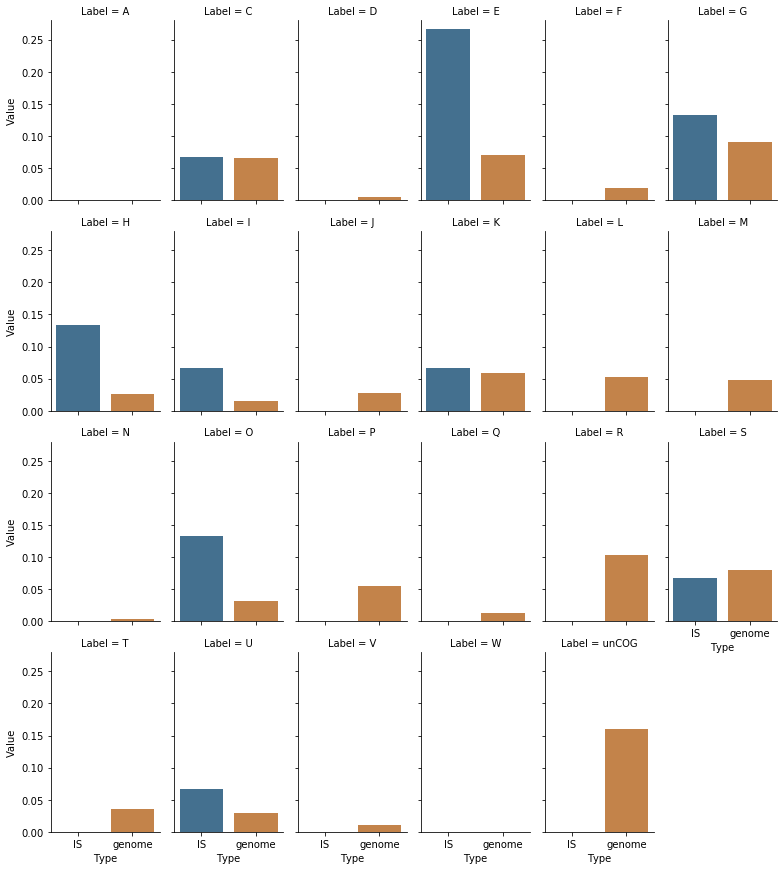

In [11]:
plot_hist_gene_categories('IS186')

In [12]:
statistical_test('IS186')

Number of insertions for which the position is listed in the NC.ptt file:  15
Number of insertions for which the position is not listed in the NC.ptt file:  7
Number of insertions for which the position is listed but there is no category:  0
Number of insertions for which the position is listed and there is a category:  15
Essential genes interrupted:  0
{'A': [], 'B': [], 'C': ['hyfA'], 'D': [], 'E': ['ggt', 'mppA', 'sdaA', 'sdaA'], 'F': [], 'G': ['ascB', 'lacZ'], 'H': ['menC', 'nadR'], 'I': ['cls'], 'J': [], 'K': ['cynR'], 'L': [], 'M': [], 'N': [], 'O': ['ccmA', 'anmK'], 'P': [], 'Q': [], 'R': [], 'S': ['ycbB'], 'T': [], 'U': ['fimA'], 'V': [], 'W': [], 'X': [], 'Y': [], 'Z': [], 'unCOG': []}


{'A': 1.0,
 'C': 1.0,
 'D': 1.0,
 'E': 0.018398003123865563,
 'F': 1.0,
 'G': 0.6398807538083598,
 'H': 0.056882257046119315,
 'I': 0.1996303598814187,
 'J': 1.0,
 'K': 0.5979891109743168,
 'L': 1.0,
 'M': 1.0,
 'N': 1.0,
 'O': 0.07999754990928377,
 'P': 1.0,
 'Q': 1.0,
 'R': 0.3901913794554538,
 'S': 1.0,
 'T': 1.0,
 'U': 0.3640568626969134,
 'V': 1.0,
 'W': 1.0,
 'unCOG': 0.1496994498672794}

Number of insertions for which the position is listed in the NC.ptt file:  56
Number of insertions for which the position is not listed in the NC.ptt file:  28
Number of insertions for which the position is listed but there is no category:  13
Number of insertions for which the position is listed and there is a category:  43
Essential genes interrupted:  0
{'A': [], 'B': [], 'C': ['napH', 'aceB'], 'D': ['minE'], 'E': ['ygjI', 'yeaU', 'astE', 'gltB', 'gadA'], 'F': ['tdk'], 'G': ['ydjF', 'rbsD', 'manX', 'yihN', 'pgaB', 'ECB_03521', 'mglB', 'idnK'], 'H': ['ECB_02854'], 'I': ['fadL', 'garR', 'ynbC', 'cls', 'fadL'], 'J': ['ansB'], 'K': ['yebK'], 'L': [], 'M': ['galF', 'rhsD'], 'N': [], 'O': ['yibF'], 'P': ['dps'], 'Q': [], 'R': ['ydjJ', 'iap', 'rarD'], 'S': ['yjgN', 'ycbC', 'ybjE'], 'T': ['yedV', 'yliF', 'yahA'], 'U': ['ECB_03531'], 'V': ['yadG', 'hsdS', 'hsdR', 'ybhG'], 'W': [], 'X': [], 'Y': [], 'Z': [], 'unCOG': ['yicL', 'ECB_01342', 'ECB_02826', 'yaaX', 'yeeJ', 'ECB_00738', 'ECB_02001',

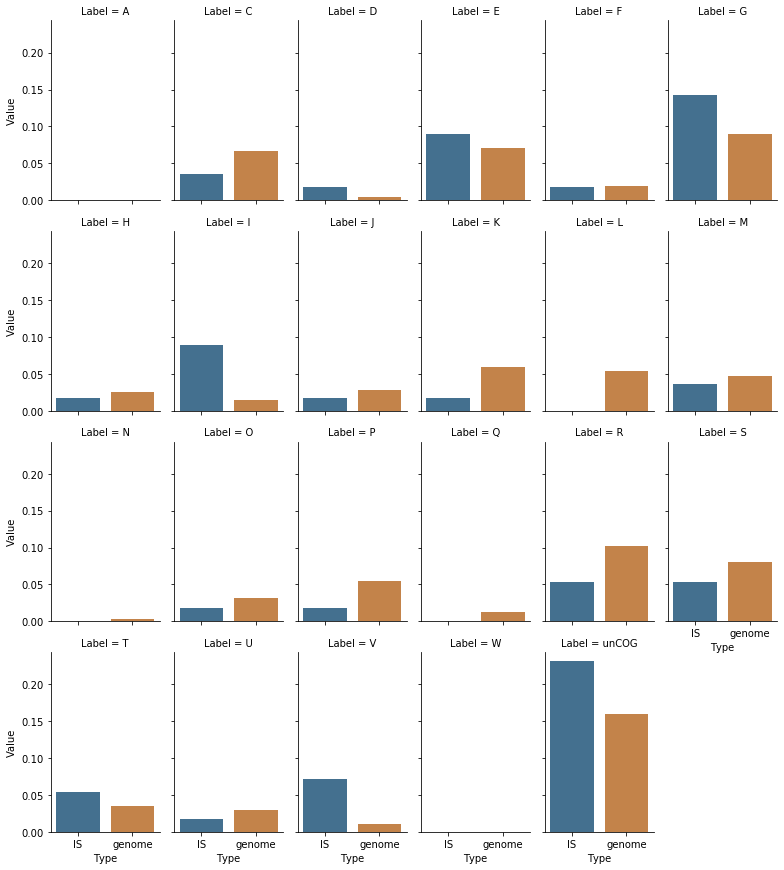

In [13]:
plot_hist_gene_categories('IS1')

In [14]:
statistical_test('IS1')

Number of insertions for which the position is listed in the NC.ptt file:  56
Number of insertions for which the position is not listed in the NC.ptt file:  28
Number of insertions for which the position is listed but there is no category:  13
Number of insertions for which the position is listed and there is a category:  43
Essential genes interrupted:  0
{'A': [], 'B': [], 'C': ['napH', 'aceB'], 'D': ['minE'], 'E': ['ygjI', 'yeaU', 'astE', 'gltB', 'gadA'], 'F': ['tdk'], 'G': ['ydjF', 'rbsD', 'manX', 'yihN', 'pgaB', 'ECB_03521', 'mglB', 'idnK'], 'H': ['ECB_02854'], 'I': ['fadL', 'garR', 'ynbC', 'cls', 'fadL'], 'J': ['ansB'], 'K': ['yebK'], 'L': [], 'M': ['galF', 'rhsD'], 'N': [], 'O': ['yibF'], 'P': ['dps'], 'Q': [], 'R': ['ydjJ', 'iap', 'rarD'], 'S': ['yjgN', 'ycbC', 'ybjE'], 'T': ['yedV', 'yliF', 'yahA'], 'U': ['ECB_03531'], 'V': ['yadG', 'hsdS', 'hsdR', 'ybhG'], 'W': [], 'X': [], 'Y': [], 'Z': [], 'unCOG': ['yicL', 'ECB_01342', 'ECB_02826', 'yaaX', 'yeeJ', 'ECB_00738', 'ECB_02001',

{'A': 1.0,
 'C': 0.5833398360083839,
 'D': 0.24708364247147768,
 'E': 0.5943150911657747,
 'F': 1.0,
 'G': 0.1633013874476939,
 'H': 1.0,
 'I': 0.001609497203392967,
 'J': 1.0,
 'K': 0.2578688921386036,
 'L': 0.11885641353700863,
 'M': 1.0,
 'N': 1.0,
 'O': 1.0,
 'P': 0.3678295574649565,
 'Q': 1.0,
 'R': 0.3687401746836072,
 'S': 0.622463137004902,
 'T': 0.45326555444168903,
 'U': 1.0,
 'V': 0.0043052854269673,
 'W': 1.0,
 'unCOG': 0.14301890405546624}

In [15]:
list_cat_I_IS1 = ['cls', 'fadL', 'fadL', 'garR', 'ynbC']
list_cat_I_IS150 = ['fadA', 'plsX', 'fadL', 'aes', 'cls', 'aes', 'acpD', 'fadL']